# FEVER dataset - Fake new detection

In [2]:
# IMPORT

# Base libraries
import pandas as pd
import numpy as np

# JSON for loading of data
import json

# NLP preprocessing
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 

# Split and feature engineering
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Model training
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

# Evaluation
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report

# Plot
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay

# Set random seed
RANDOM_SEED = 1234

## Preprocessing

### Loading the data and descriptive statisitics

In [3]:
# File paths
fever_test_path = "FEVER/test.jsonl"
fever_train_path = "FEVER/train.jsonl"


# Load test data 
with open(fever_test_path, 'r') as json_file:
    lines = json_file.read().splitlines()
fever_test = pd.DataFrame(lines)
fever_test.columns = ['json_element']
fever_test['json_element'].apply(json.loads)

fever_test = pd.json_normalize(fever_test['json_element'].apply(json.loads))


# Load train data
with open(fever_train_path, 'r') as json_file:
    lines = json_file.read().splitlines()
fever_train = pd.DataFrame(lines)
fever_train.columns = ['json_element']
fever_train['json_element'].apply(json.loads)

fever_train = pd.json_normalize(fever_train['json_element'].apply(json.loads))


# Merge the two datasets (test+train)
fever = pd.concat([fever_test, fever_train], axis=0, ignore_index=True)

#### Handeling the label column

In [4]:
# Remove the instances with the label 'NOT ENOUGH INFO'
fever = fever[fever['label'] != 'NOT ENOUGH INFO']


# Change the label encoding to 1 ('REFUTES', fake) and 0 ('SUPPORTS', real)
fever = fever.replace({'label':{'SUPPORTS': 1, 'REFUTES': 0}})


# Rename the 'label' column to 'is_real' (for easier understanding of the values)
fever.rename(columns={'label': 'is_real'}, inplace=True)

In [5]:
# Remove duplicates
fever  = fever.drop_duplicates(subset=('is_real', 'claim'))

In [6]:
# Sample 50000 instances
fever_sample = fever.sample(50000, axis='index', random_state=RANDOM_SEED)

In [7]:
# Head of the dataset 
fever_sample.head(10)

,id,verifiable,is_real,claim,evidence
73794,18697,VERIFIABLE,1,Sue Bird was the first overall pick of the 200...,"[[[34315, 41629, Sue_Bird, 1]]]"
93617,50780,VERIFIABLE,0,Clint Eastwood is not a director.,"[[[67127, 77925, Clint_Eastwood, 5]], [[67127,..."
73294,106034,VERIFIABLE,1,Kong: Skull Island was made in 2017 by Legenda...,"[[[125235, 139571, Kong-COLON-_Skull_Island, 1..."
151047,50433,VERIFIABLE,1,Michael Caine starred in Get Carter.,"[[[66789, 77619, Michael_Caine, 5]]]"
123591,113441,VERIFIABLE,0,Red Velvet (band) is incapable of being formed...,"[[[133080, 147957, Red_Velvet_-LRB-band-RRB-, ..."
145856,124812,VERIFIABLE,1,The Communist Party of the Soviet Union was th...,"[[[146491, 161469, Communist_Party_of_the_Sovi..."
117583,21532,VERIFIABLE,1,"Apollo 11 was launched from Merritt Island, Fl...","[[[37316, 45182, Apollo_11, 8]]]"
42885,216557,VERIFIABLE,0,The Who is a funk band.,"[[[257290, 256312, The_Who, 0]]]"
161559,75944,VERIFIABLE,1,Glenn Frey cowrote most Eagles songs with Don ...,"[[[92756, 105622, Glenn_Frey, 1]]]"
19535,13815,VERIFIABLE,1,Theresa May worked for Bank of England.,"[[[29066, 35459, Theresa_May, 6]]]"


#### Handeling the other columns

In [8]:
# Remove unnecessary features from the dataset
fever_sample = fever_sample.drop(columns=['id', 'verifiable', 'evidence'])


# Rename the 'claim' column to 'text'
fever_sample.rename(columns={'claim': 'text'}, inplace=True)

#### General info about the final dataset

In [9]:
# Shape of data object
fever_sample.shape

(50000, 2)

In [10]:
# Info about data object
fever_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 73794 to 104460
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   is_real  50000 non-null  int64 
 1   text     50000 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [11]:
# Column names of dataframe
fever_sample.columns

Index(['is_real', 'text'], dtype='object')

### Missing values

In [12]:
# Check how many missing values there are in the dataset
fever_sample.isnull().sum().sum()

0

In [13]:
# Check the distinct values in the 'is_real' column
print(fever_sample['is_real'].unique())

[1 0]


In [14]:
# Number of instances with label ('is_real') 0 and 1
fever_sample["is_real"].value_counts()

1    34910
0    15090
Name: is_real, dtype: int64

### Preparing data for analysis

#### Tokenization

In [15]:
# Create new column with tokens
fever_sample['tokens'] = fever_sample.apply(lambda row: word_tokenize(row['text']), axis=1)

#### Lemmatization

In [16]:
# Instantiate the lemmatizer
lemmatizer = WordNetLemmatizer()


# Create new column with lemmas
fever_sample['lemma'] = fever_sample.apply(lambda row: [lemmatizer.lemmatize(token.lower()) for token in row["tokens"]], axis=1)

#### Stopword removal

In [17]:
# Load the english stopwords
english_stop_words = stopwords.words('english')


# Create new column without stopwords
fever_sample['stopword'] = fever_sample.apply(lambda row: [token for token in row["lemma"] if token not in english_stop_words], axis=1)

#### Final string creation

In [18]:
# Create new column with joined tokens (as TD-IDF takes a string as input)
fever_sample['final'] = fever_sample.apply(lambda row: " ".join(row['stopword']), axis=1)

In [19]:
# Head of the created dataaset
fever_sample.head()

,is_real,text,tokens,lemma,stopword,final
73794,1,Sue Bird was the first overall pick of the 200...,"[Sue, Bird, was, the, first, overall, pick, of...","[sue, bird, wa, the, first, overall, pick, of,...","[sue, bird, wa, first, overall, pick, 2002, wn...",sue bird wa first overall pick 2002 wnba draft .
93617,0,Clint Eastwood is not a director.,"[Clint, Eastwood, is, not, a, director, .]","[clint, eastwood, is, not, a, director, .]","[clint, eastwood, director, .]",clint eastwood director .
73294,1,Kong: Skull Island was made in 2017 by Legenda...,"[Kong, :, Skull, Island, was, made, in, 2017, ...","[kong, :, skull, island, wa, made, in, 2017, b...","[kong, :, skull, island, wa, made, 2017, legen...",kong : skull island wa made 2017 legendary ent...
151047,1,Michael Caine starred in Get Carter.,"[Michael, Caine, starred, in, Get, Carter, .]","[michael, caine, starred, in, get, carter, .]","[michael, caine, starred, get, carter, .]",michael caine starred get carter .
123591,0,Red Velvet (band) is incapable of being formed...,"[Red, Velvet, (, band, ), is, incapable, of, b...","[red, velvet, (, band, ), is, incapable, of, b...","[red, velvet, (, band, ), incapable, formed, s...",red velvet ( band ) incapable formed s.m . ent...


#### Splitting data and feature engineering

##### Splitting

In [20]:
# Split the data into train set and test set (70/30 split)
X_train, X_test, y_train, y_test = train_test_split(fever_sample['final'], fever_sample['is_real'], test_size=0.3, random_state=RANDOM_SEED, stratify=fever_sample['is_real'])

##### TF-IDF

In [21]:
# Initialize vectorizer with token pattern to remove numbers, single characters and 
# non-latin alphabet characters
vectorizer = TfidfVectorizer(token_pattern=r'(?u)\b[A-Za-z]{3,}\b')


# Fit-transform to taining data
X_train_tfidf = vectorizer.fit_transform(X_train)


# Transform test data
X_test_tfidf = vectorizer.transform(X_test)

In [22]:
# # Matrix to see the result
# df_train_tfidf = pd.DataFrame(X_train_tfidf.toarray(), columns=vectorizer.get_feature_names_out(), index=range(1, len(X_train)+1))


# # Display the TF-IDF matrix
# print("TF-IDF Matrix:")
# print(df_train_tfidf.head())

In [23]:
# # Matrix to see the result
# df_test_tfidf = pd.DataFrame(X_test_tfidf.toarray(), columns=vectorizer.get_feature_names_out(), index=range(1, len(X_test)+1))


# # Display the TF-IDF matrix
# print("TF-IDF Matrix:")
# print(df_test_tfidf.head())

## Model training

### Support Vector Machine/Classifier

In [24]:
# Instantiate SVM
svc = SVC(random_state=RANDOM_SEED)


# Parameter grid dictionary
param_grid_svc = [
    {'C':[1.0, 10.0, 100.0], 
     'kernel':['linear', 'poly', 'rbf']}
]


# Instantiate GridSearchCV and fit it to the training data
search_svc = GridSearchCV(svc, param_grid_svc, cv=5, n_jobs=-1)
search_svc.fit(X_train_tfidf, y_train)


# Print the best estimator
print(search_svc.best_estimator_)


# Save the best parameters in a variable 
best_params_svc = search_svc.best_params_

SVC(kernel='linear', random_state=1234)


#### Final model

In [25]:
# Instantiate SVM
svc = SVC(**best_params_svc, random_state=RANDOM_SEED)


# Fit the model to training data
svc.fit(X_train_tfidf, y_train)

SVC(kernel='linear', random_state=1234)

In [26]:
# Predict the labels of the test set
svc_pred_labels = svc.predict(X_test_tfidf)

### Random Forest

#### Grid search

In [27]:
# Instantiate Random Forest
rf = RandomForestClassifier(random_state=RANDOM_SEED)


# Parameter grid dictionary
grid_dict_rf = [
    {'max_depth': [None, 10, 20], 
     'min_samples_split': [2, 5, 10],
     'n_estimators':[50, 100, 200]}
]


# Instantiate GridSearchCV and fit it to the training data
search_rf = GridSearchCV(rf, grid_dict_rf, cv=5, n_jobs=-1) 
search_rf.fit(X_train_tfidf, y_train)


# Print the best estimator
print(search_rf.best_estimator_)


# Save the best parameters in a variable 
best_params_rf = search_rf.best_params_

RandomForestClassifier(min_samples_split=10, n_estimators=200,
                       random_state=1234)


#### Final model

In [28]:
# Instantiate Random Forest
rf = RandomForestClassifier(**best_params_rf, random_state=RANDOM_SEED)


# Fit the model to training data
rf.fit(X_train_tfidf, y_train)

RandomForestClassifier(min_samples_split=10, n_estimators=200,
                       random_state=1234)

In [29]:
# Predict the labels of the test set
rf_pred_labels = rf.predict(X_test_tfidf)

### Multinomial Naive Bayes

In [30]:
# Instantiate Multinomial Naive Bayes
mnb = MultinomialNB()


# Parameter grid dictionary
grid_dict_mnb = [
    {'alpha': [0.01, 0.1, 1]}
]


# Instantiate GridSearchCV and fit it to the training data
search_mnb = GridSearchCV(mnb, grid_dict_mnb, cv=5, n_jobs=-1) 
search_mnb.fit(X_train_tfidf, y_train)


# Print the best estimator
print(search_mnb.best_estimator_)


# Save the best parameters in a variable 
best_params_mnb = search_mnb.best_params_

MultinomialNB(alpha=1)


#### Final model

In [31]:
# Instantiate 
mnb = MultinomialNB(**best_params_mnb)


# Fit the model to training data
mnb.fit(X_train_tfidf, y_train)

MultinomialNB(alpha=1)

In [32]:
# Predict the labels of the test set
mnb_pred_labels = mnb.predict(X_test_tfidf)

## Model evaluation

### Support Vector Machine/Classifier

In [46]:
# Calculate different performance measures
accuracy_score_svc = accuracy_score(y_test , svc_pred_labels)
precision_score_svc = precision_score(y_test , svc_pred_labels, average='weighted')
recall_score_svc = recall_score(y_test, svc_pred_labels, average='weighted')
f1_score_svc = f1_score(y_test, svc_pred_labels, average='weighted')


# Print the different performance measures
print("SVC Results:",
      "\nDataset:\t FEVER",
      "\nModel parameters:", search_svc.best_params_,
      "\nAccuracy:\t", accuracy_score_svc,
      "\nPrecision:\t", precision_score_svc, 
      "\nRecall:\t\t",  recall_score_svc, 
      "\nF1-score:\t", f1_score_svc)


# Classification report for SVC
print('\n\n\nClassification report SVC (FEVER):\n')
print(classification_report(y_test, svc_pred_labels, digits=4))

SVC Results: 
Dataset:	 FEVER 
Model parameters: {'C': 1.0, 'kernel': 'linear'} 
Accuracy:	 0.7535333333333334 
Precision:	 0.7524551878388759 
Recall:		 0.7535333333333334 
F1-score:	 0.7115104409547057



Classification report SVC (FEVER):

              precision    recall  f1-score   support

           0     0.7485    0.2761    0.4034      4527
           1     0.7542    0.9599    0.8447     10473

    accuracy                         0.7535     15000
   macro avg     0.7513    0.6180    0.6241     15000
weighted avg     0.7525    0.7535    0.7115     15000



### Random Forest

In [47]:
# Calculate different performance measures
accuracy_score_rf = accuracy_score(y_test , rf_pred_labels)
precision_score_rf = precision_score(y_test , rf_pred_labels, average='weighted')
recall_score_rf = recall_score(y_test, rf_pred_labels, average='weighted')
f1_score_rf = f1_score(y_test, rf_pred_labels, average='weighted')


# Print the different performance measures
print("Random Forest Results:",
      "\nDataset:\t FEVER",
      "\nModel parameters:", search_rf.best_params_,
      "\nAccuracy:\t", accuracy_score_rf,
      "\nPrecision:\t", precision_score_rf, 
      "\nRecall:\t\t",  recall_score_rf, 
      "\nF1-score:\t", f1_score_rf)


# Classification report for Random Forest
print('\n\n\nClassification report Random Forest (FEVER):\n')
print(classification_report(y_test, rf_pred_labels, digits=4))

Random Forest Results: 
Dataset:	 FEVER 
Model parameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200} 
Accuracy:	 0.7340666666666666 
Precision:	 0.7139602758101113 
Recall:		 0.7340666666666666 
F1-score:	 0.7104431013365289



Classification report Random Forest (FEVER):

              precision    recall  f1-score   support

           0     0.6011    0.3534    0.4451      4527
           1     0.7628    0.8986    0.8251     10473

    accuracy                         0.7341     15000
   macro avg     0.6819    0.6260    0.6351     15000
weighted avg     0.7140    0.7341    0.7104     15000



### Multinomial Naive Bayes

In [48]:
# Calculate different performance measures
accuracy_score_mnb = accuracy_score(y_test , mnb_pred_labels)
precision_score_mnb = precision_score(y_test , mnb_pred_labels, average='weighted')
recall_score_mnb = recall_score(y_test, mnb_pred_labels, average='weighted')
f1_score_mnb = f1_score(y_test, mnb_pred_labels, average='weighted')


# Print the different performance measures
print("Multinomial Naive Bayes:",
      "\nDataset:\t FEVER",
      "\nModel parameters:", search_mnb.best_params_,
      "\nAccuracy:\t", accuracy_score_mnb,
      "\nPrecision:\t", precision_score_mnb, 
      "\nRecall:\t\t",  recall_score_mnb, 
      "\nF1-score:\t", f1_score_mnb)


# Classification report for Multinomial Naive Bayes
print('\n\n\nClassification report Multinomial Naive Bayes (FEVER):\n')
print(classification_report(y_test, mnb_pred_labels, digits=4))

Multinomial Naive Bayes: 
Dataset:	 FEVER 
Model parameters: {'alpha': 1} 
Accuracy:	 0.7238 
Precision:	 0.7142675699287383 
Recall:		 0.7238 
F1-score:	 0.6567942736264131



Classification report Multinomial Naive Bayes (FEVER):

              precision    recall  f1-score   support

           0     0.6857    0.1566    0.2550      4527
           1     0.7266    0.9690    0.8305     10473

    accuracy                         0.7238     15000
   macro avg     0.7062    0.5628    0.5427     15000
weighted avg     0.7143    0.7238    0.6568     15000



### AUC and AUPRC plots

Average Precision SVC (fake news): 0.5798311295770193
Average Precision RF (fake news): 0.5629081336958024
Average Precision MNB (fake news): 0.512796549871164
Average Precision SVC (real news): 0.8165396676344869
Average Precision RF (real news): 0.8177814429991608
Average Precision MNB (real news): 0.8137884234084987


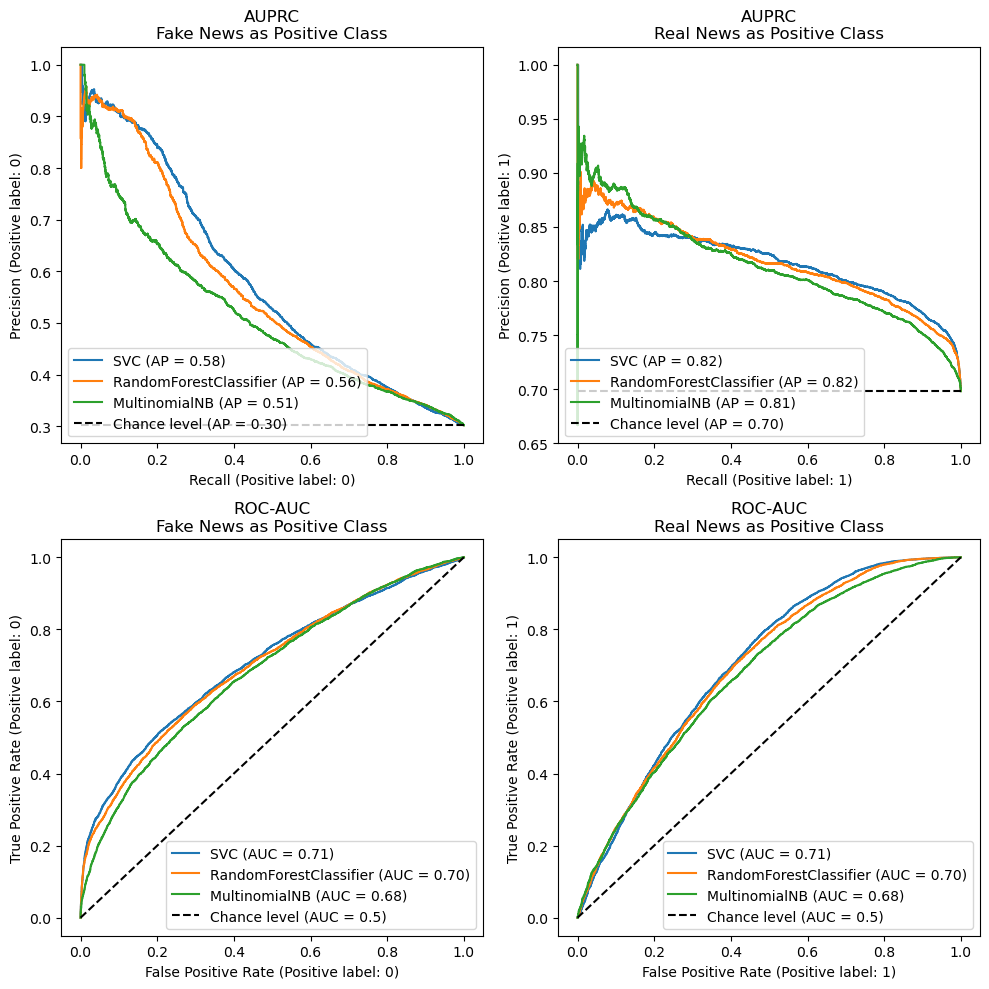

In [45]:
# Create plot canvas with subplot spaces
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# AUPRC
print('Average Precision SVC (fake news):',
    PrecisionRecallDisplay.from_estimator(
    svc, X_test_tfidf, y_test, pos_label=mnb.classes_[0], ax=axs[0, 0]).average_precision)

print('Average Precision RF (fake news):',
    PrecisionRecallDisplay.from_estimator(
    rf, X_test_tfidf, y_test, pos_label=mnb.classes_[0], ax=axs[0, 0]).average_precision)

print('Average Precision MNB (fake news):',
    PrecisionRecallDisplay.from_estimator(
    mnb, X_test_tfidf, y_test, pos_label=mnb.classes_[0], ax=axs[0, 0],
    plot_chance_level=True).average_precision)

print('Average Precision SVC (real news):',
    PrecisionRecallDisplay.from_estimator(
    svc, X_test_tfidf, y_test, pos_label=mnb.classes_[1], ax=axs[0, 1]).average_precision)

print('Average Precision RF (real news):',
    PrecisionRecallDisplay.from_estimator(
    rf, X_test_tfidf, y_test, pos_label=mnb.classes_[1], ax=axs[0, 1]).average_precision)

print('Average Precision MNB (real news):',
    PrecisionRecallDisplay.from_estimator(
    mnb, X_test_tfidf, y_test, pos_label=mnb.classes_[1], ax=axs[0, 1],
    plot_chance_level=True).average_precision)

axs[0, 0].set_title('AUPRC\nFake News as Positive Class')
axs[0, 1].set_title('AUPRC\nReal News as Positive Class')


# AUC
RocCurveDisplay.from_estimator(
    svc, X_test_tfidf, y_test, pos_label=mnb.classes_[0], ax=axs[1, 0])

RocCurveDisplay.from_estimator(
    rf, X_test_tfidf, y_test, pos_label=mnb.classes_[0], ax=axs[1, 0])

RocCurveDisplay.from_estimator(
    mnb, X_test_tfidf, y_test, pos_label=mnb.classes_[0], ax=axs[1, 0],
    plot_chance_level=True)

RocCurveDisplay.from_estimator(
    svc, X_test_tfidf, y_test, pos_label=mnb.classes_[1], ax=axs[1, 1])

RocCurveDisplay.from_estimator(
    rf, X_test_tfidf, y_test, pos_label=mnb.classes_[1], ax=axs[1, 1])

RocCurveDisplay.from_estimator(
    mnb, X_test_tfidf, y_test, pos_label=mnb.classes_[1], ax=axs[1, 1],
    plot_chance_level=True)

axs[1, 0].set_title('ROC-AUC\nFake News as Positive Class')
axs[1, 1].set_title('ROC-AUC\nReal News as Positive Class')

plt.tight_layout()